In [27]:
%pip install gymnasium
%pip install gymnasium[toy-text]

%pip install torch
%pip install torchvision
%pip install torchaudio
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import matplotlib.pyplot as plt

## Environment

Użyłem dokładnie takiego samego środowiska jak w pliku `main.ipynb` poprzez zutylizowanie zmiennej `RANDOM_STATE`

In [29]:
from typing import Final

DISCOUNT_FACTOR: Final[float] = 0.9
RANDOM_STATE: Final[int] = 42
EPISODES: Final[int] = 10_000

In [30]:
from gymnasium import make
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Default simulation
env = make("FrozenLake-v1", desc=generate_random_map(4, 0.8, RANDOM_STATE), is_slippery=False)

In [31]:
num_states: int = env.observation_space.n
num_actions: int = env.action_space.n

## Deep Q-Network (DQN)

In [32]:
import torch
from torch.nn import Module, Linear, MSELoss
from torch.nn.functional import relu


class DeepQNetwork(Module):
    def __init__(self, in_states: int = 16, h1_nodes: int = 32, out_actions: int = 4) -> None:
        super().__init__()

        self.layer1: Linear = Linear(in_states, h1_nodes)
        self.layer2: Linear = Linear(h1_nodes, h1_nodes)
        self.output_layer: Linear = Linear(h1_nodes, out_actions)

    def forward(self, x):
        return self.output_layer(
            relu(
                self.layer2(
                    relu(
                        self.layer1(x)
                    )
                )
            )
        )

In [33]:
def to_tensor(state) -> torch.Tensor:
    tensor = torch.zeros(num_states)
    tensor[state] = 1.
    return tensor

In [34]:
from collections import deque
from random import sample, random

class Memory:
    def __init__(self, max_len: int) -> None:
        self.memory: deque = deque([], maxlen=max_len)

    def append(self, transition) -> None:
        self.memory.append(transition)

    def sample(self, sample_size: int):
        return sample(self.memory, sample_size)

    def __len__(self) -> int:
        return len(self.memory)

In [35]:
memory: Memory = Memory(1_024)

policy: DeepQNetwork = DeepQNetwork(num_states, 32, num_actions)
target: DeepQNetwork = DeepQNetwork(num_states, 32, num_actions)

target.load_state_dict(policy.state_dict())

<All keys matched successfully>

In [36]:
from torch.optim import Adam

optimizer: Adam = Adam(policy.parameters(), lr=0.02)

rewards_per_episode = np.zeros(EPISODES)

epsilon: float = 1.
step_count: int = 0

In [37]:
from torch import FloatTensor

for i in range(EPISODES):
    state = env.reset()[0]

    while True:
        if random() < epsilon:
            action = env.action_space.sample()
        else:          
            with torch.no_grad():
                action = policy(to_tensor(state)).argmax().item()

        new_state, reward, terminated, truncated, _ = env.step(action)
        memory.append((state, action, new_state, reward, terminated))

        state = new_state

        step_count += 1
        
        if terminated or truncated:
            break

    if reward == 1:
        rewards_per_episode[i] = 1.

    if len(memory) > 64 and np.sum(rewards_per_episode) > 0:
        mini_batch = memory.sample(64)

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target_tensor = FloatTensor([reward])
            else:
                with torch.no_grad():
                    target_tensor = FloatTensor(
                        reward + DISCOUNT_FACTOR * target(to_tensor(new_state)).max()
                    )

            current_q = policy(to_tensor(state))
            current_q_list.append(current_q)

            target_q = target(to_tensor(state))
            target_q[action] = target_tensor
            target_q_list.append(target_q)

        loss = MSELoss()(torch.stack(current_q_list), torch.stack(target_q_list))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epsilon = max(epsilon - 1 / EPISODES, 0)

        if step_count > 10:
            target.load_state_dict(policy.state_dict())
            step_count = 0

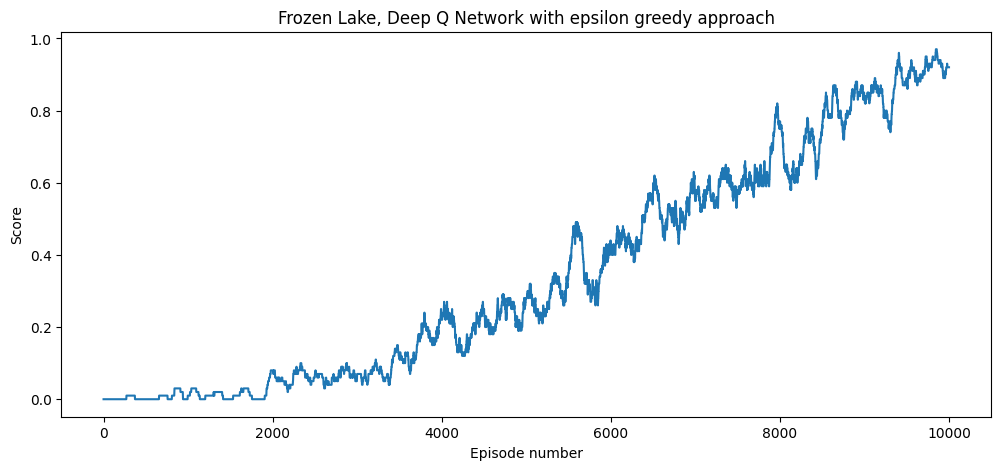

In [38]:
plt.figure(1, figsize=(12, 5))
plt.title("Frozen Lake, Deep Q Network with epsilon greedy approach")
plt.xlabel("Episode number")
plt.ylabel("Score")

sum_rewards = np.zeros(EPISODES)
for x in range(EPISODES):
    sum_rewards[x] = np.sum(rewards_per_episode[max(0, x - 100): (x + 1)] / 100)
plt.subplot(111)
plt.plot(sum_rewards)
plt.show()

In [39]:
print(np.sum(sum_rewards[:1_000]) / 1_000)
print(np.sum(sum_rewards) / EPISODES)
print(sum_rewards[-1])

0.0050999999999999995
0.34715199999999996
0.9199999999999999


## SARSA

In [40]:
from random import uniform

def sarsa(alpha: float):
    epsilon: float = 1.0
    
    q_table = np.zeros((num_states, num_actions))
    
    reward_array = np.zeros(EPISODES)
    for i in range(EPISODES):
        state = env.reset()[0]
        if uniform(0., 1.) >= epsilon:
            action = np.argmax(q_table[state, :])
        else:
            action = np.random.randint(num_actions)

        total_rewards = 0.
        
        while True:
            new_state, reward, terminated, truncated, _ = env.step(action)
            
            if uniform(0., 1.) >= epsilon:
                new_action = np.argmax(q_table[state, :])
            else:
                new_action = np.random.randint(num_actions)

            q_table[state, action] += alpha * (reward + (DISCOUNT_FACTOR * q_table[new_state, new_action]) - q_table[state, action])

            total_rewards += reward
            
            if terminated or truncated:
                break

            state, action = new_state, new_action

        epsilon = max(epsilon - 1. / EPISODES, 0.)

        reward_array[i] = total_rewards
            
    return q_table, reward_array

table, rewards_per_episode = sarsa(0.1)

table

array([[2.66357922e-05, 2.54194882e-05, 2.55037484e-05, 2.62524572e-05],
       [9.91774373e-04, 0.00000000e+00, 0.00000000e+00, 1.15319140e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.53685076e-05, 1.49302109e-05, 0.00000000e+00, 4.56453882e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.54130620e-01, 4.68706099e-04, 0.00000000e+00],
       [7.20414839e-03, 0.00000000e+00, 8.00460932e-04, 0.00000000e+00],
       [2.60622980e-04, 2.10866767e-05, 5.44643322e-04, 4.78429282e-06],
       [4.08089837e-03, 0.00000000e+00, 3.25512890e-06, 0.00000000e+00],
       [4.07173787e-08, 6.12910474e-01, 0.00000000e+00, 2.80395084e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.10708404e-05, 4.23372932e-05, 0.00000000e+00, 4.24141207e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

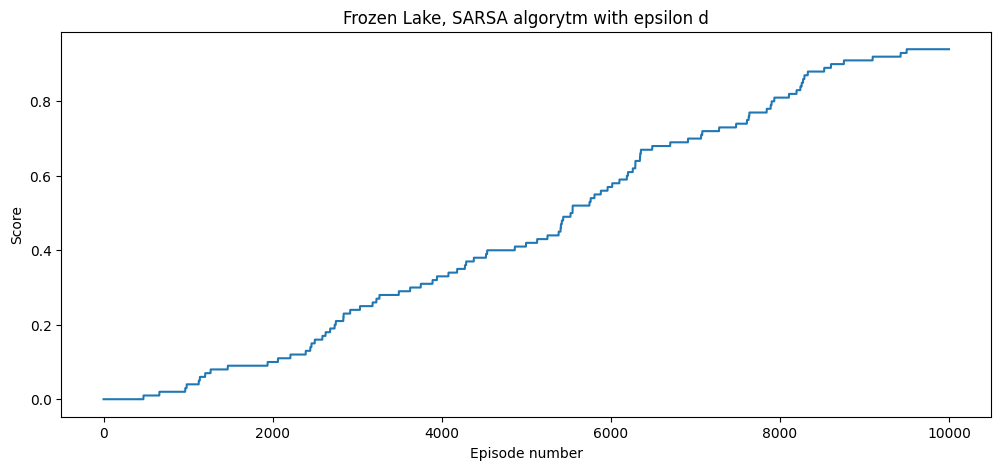

In [43]:
plt.figure(1, figsize=(12, 5))
plt.title("Frozen Lake, SARSA algorytm with epsilon d")
plt.xlabel("Episode number")
plt.ylabel("Score")

sum_rewards = np.zeros(EPISODES)
for x in range(EPISODES):
    sum_rewards[x] = np.sum(rewards_per_episode[: x]) / 100
plt.subplot(111)
plt.plot(sum_rewards)
plt.show()

In [46]:
print(np.sum(rewards_per_episode[:1_000]) / 1_000)
print(np.sum(sum_rewards) / EPISODES)
print(sum_rewards[-1])

0.004
0.460566
0.94
